In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import shap

cmap='viridis'
sys.path.insert(1, '../')
from LibHelperFuncs import *

rstate = 0
np.random.seed(0)
njob = -1
global_trees = 1000

plt.rcParams['axes.grid'] = False

In [4]:
originalDat = np.genfromtxt("../../Data/data_bas_preprocessing.csv", delimiter=',')
originalDat_pd = pd.read_csv("../../Data/data_bas_preprocessing_pd.csv")

X = originalDat[:,:-1]
Y = originalDat[:,-1]
C = originalDat_pd.columns

lower_thres = 1e-3

In [3]:
def compute_carried_shap(s_vals, comps, X):
    shap_values_r = np.arange(0, X.shape[0]).reshape(-1, 1)
    carried_shap_vals = np.apply_along_axis((lambda x : s_vals[x].reshape(-1, 1).T @ comps), 1, shap_values_r).reshape(-1, X.shape[1])
    return carried_shap_vals

def mean_carried_shap(s_vals, comps, X):
    
    sump = np.sqrt(np.mean(comps ** 2, axis=0))
    sump[np.where(sump == 0)[0]] = 1
    sump = sump ** 2
    sump[np.where(sump < 1e-8)[0]] = 1
    
    t = compute_carried_shap(s_vals, comps, X) / sump
    return np.mean(np.abs(t), axis=0) 

In [4]:
rf = LinearRegression()
rf.fit(X, Y)

exp = shap.LinearExplainer(rf, X)
s_vals = exp.shap_values(X)
ov_shap = np.mean(np.abs(s_vals), axis=0)

In [5]:
pca = PCA(n_components=50)
pca.fit(X)
comps = pca.components_
X_r = (comps @ X.T).T

rf = LinearRegression()
rf.fit(X_r, Y)

exp = shap.LinearExplainer(rf, X_r)
s_vals = exp.shap_values(X_r)
ov_reduced_shap = mean_carried_shap(s_vals, pca.components_, X)

In [6]:
urscorecv=[]
rscorecv=[]
urscorel2=[]
rscorel2=[]

renge = range(1, 120)

for k in renge:
    print(k)
    X_l = X[:,np.argsort(ov_shap)[::-1][:k]]

    rf = LinearRegression()

    rf.fit(X_l, Y)
    urscorel2.append(np.sqrt(np.mean((rf.predict(X_l) - Y) ** 2)))
    urscorecv.append(linereg_model_crosseval(X_l, Y))

    X_r = X[:,np.argsort(ov_reduced_shap)[::-1][:k]]

    rf = LinearRegression()

    rf.fit(X_r, Y)
    rscorel2.append(np.sqrt(np.mean((rf.predict(X_r) - Y) ** 2)))
    rscorecv.append(linereg_model_crosseval(X_r, Y))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


0.0018263393407634133 0.0007300165352244427
2.334478159342606e+20 471986955778.1786


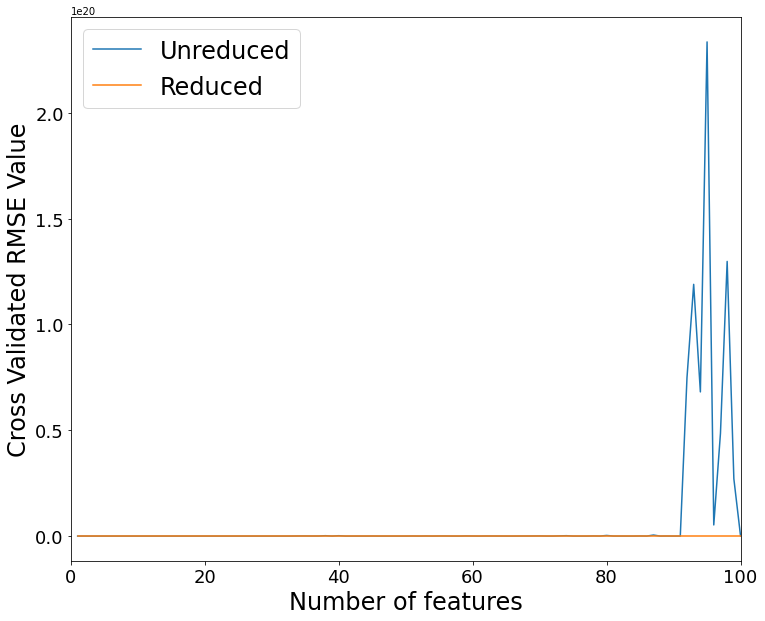

In [7]:
plt.figure(figsize=(12,10))

plt.plot(renge, urscorecv, label = 'Unreduced')
plt.plot(renge, rscorecv, label='Reduced')

plt.xlabel('Number of features', fontsize=24)
plt.ylabel("Cross Validated RMSE Value", fontsize=24)

plt.xlim([0, 100])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=24)

print(min(urscorecv), min(rscorecv))
print(max(urscorecv), max(rscorecv))

0.0018263393407634133 0.0007300165352244427
2.334478159342606e+20 471986955778.1786


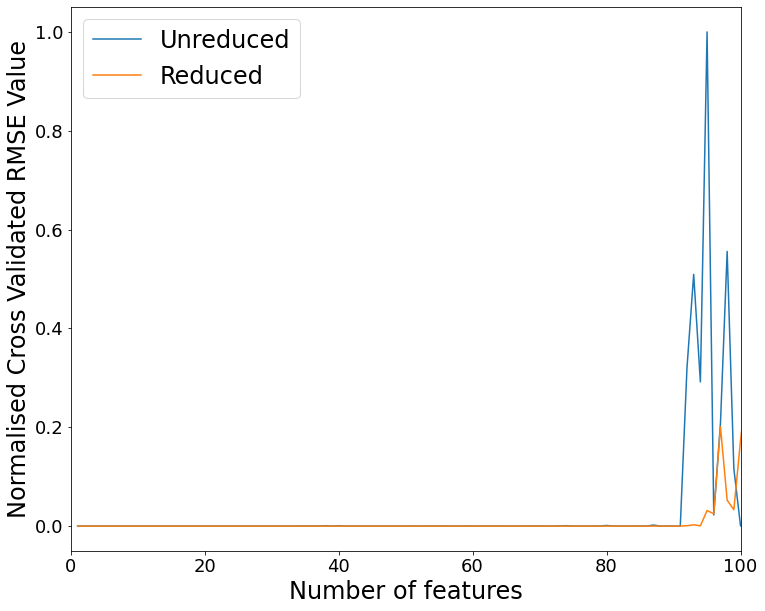

In [8]:
plt.figure(figsize=(12,10))

plt.plot(renge, urscorecv / np.max(urscorecv), label = 'Unreduced')
plt.plot(renge, rscorecv / np.max(rscorecv), label='Reduced')

plt.xlabel('Number of features', fontsize=24)
plt.ylabel("Normalised Cross Validated RMSE Value", fontsize=24)

plt.xlim([0, 100])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=24)

print(min(urscorecv), min(rscorecv))
print(max(urscorecv), max(rscorecv))

0.02440289884529109 0.023255145750512032


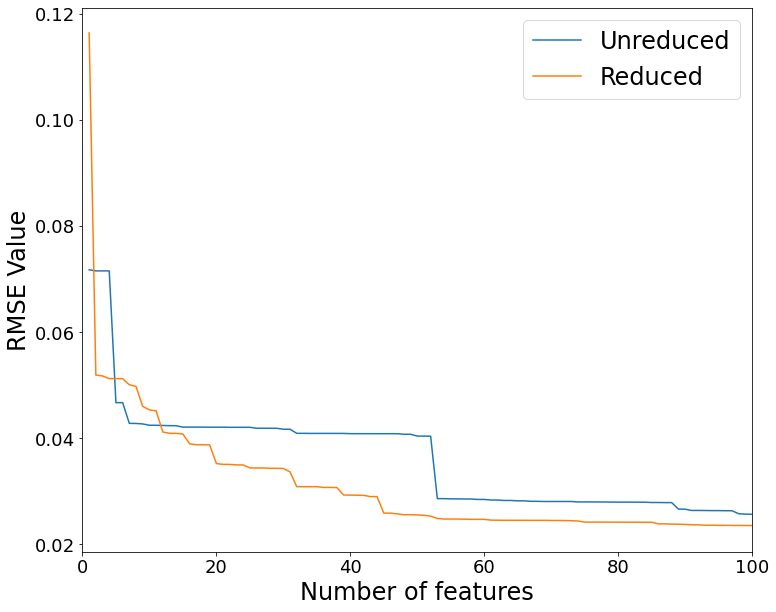

In [10]:
plt.figure(figsize=(12,10))

plt.plot(renge, urscorel2, label = 'Unreduced')
plt.plot(renge, rscorel2, label='Reduced')

plt.xlabel('Number of features', fontsize=24)
plt.ylabel("RMSE Value", fontsize=24)

plt.xlim([0,100])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=24)

print(min(urscorel2), min(rscorel2))